# Experiment 3

Here we have the same set up as experiment 2, but we want to predict more frames in the future.

We have to answer 2 questions:
1. How many frames in the past are needed?
2. How many frames in the future can we predict?

These two questions are related, so we will try different combinations.

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

# import functions
import sys
sys.path.insert(0, '../')
from my_functions import *

from sklearn import preprocessing

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

## Read data

In [3]:
data = pd.read_csv('../../data/processed/trajectories.csv')

In [4]:
# the particle and coordinate we are trying to predict
particle = 0
coordinate = 'y'

coordinate_df = data[data['particle'] == particle][coordinate].reset_index(drop=True)
coordinate_df.head()

0    24.420047
1    22.786106
2    23.797221
3    22.500377
4    22.045133
Name: y, dtype: float64

In [5]:
# scale the data
min_max_scaler = preprocessing.MinMaxScaler()
coordinates_scaled = coordinate_df.copy()
coordinates_scaled = min_max_scaler.fit_transform(np.reshape(coordinate_df.values.astype(float), (-1, 1)))

In [6]:
# split into train and test sets
train_size = int(len(coordinates_scaled) * 0.67)
test_size = len(coordinates_scaled) - train_size
train, test = coordinates_scaled[0:train_size,:], coordinates_scaled[train_size:len(coordinates_scaled),:]
print(f'Train length: {len(train)}')
print(f'Test length: {len(test)}')

Train length: 536
Test length: 264


In [217]:
# choose a number of time steps
n_steps_in, n_steps_out = 2, 7

# convert into input/output
X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])

## Define the model and train

In [218]:
# define model
def create_model():
    model = Sequential()
    
    model.add(SimpleRNN(32, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(Dense(n_steps_out))
    
    model.compile(optimizer='adam', loss='mae')
    
    return model

In [219]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = '../../models/rnn_3/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=0, 
    save_weights_only=True,
    period=5)

In [220]:
# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
history = model.fit(
    X_train, 
    y_train,
    epochs=100,
    batch_size=10,
    callbacks=[cp_callback],
    validation_data=(X_test,y_test))

Train on 528 samples, validate on 256 samples
Epoch 1/100
528/528 [==============================] - 0s 455us/step - loss: 0.3766 - val_loss: 0.3737
Epoch 2/100
528/528 [==============================] - 0s 127us/step - loss: 0.0957 - val_loss: 0.1032
Epoch 3/100
528/528 [==============================] - 0s 109us/step - loss: 0.0320 - val_loss: 0.0404
Epoch 4/100
528/528 [==============================] - 0s 121us/step - loss: 0.0277 - val_loss: 0.0318
Epoch 5/100
528/528 [==============================] - 0s 113us/step - loss: 0.0279 - val_loss: 0.0314
Epoch 6/100
528/528 [==============================] - 0s 115us/step - loss: 0.0272 - val_loss: 0.0302
Epoch 7/100
528/528 [==============================] - 0s 123us/step - loss: 0.0272 - val_loss: 0.0356
Epoch 8/100
528/528 [==============================] - 0s 117us/step - loss: 0.0275 - val_loss: 0.0338
Epoch 9/100
528/528 [==============================] - 0s 119us/step - loss: 0.0273 - val_loss: 0.0343
Epoch 10/100
528/528 [=====

## Evaluate

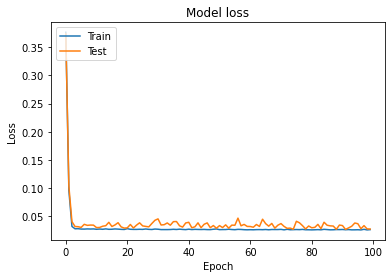

In [221]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [222]:
print('The model performance for X_train')
pred_train = evaluate(X_train, y_train, model)
print('The model performance for X_test')
pred_test = evaluate(X_test, y_test, model)

The model performance for X_train
--------------------------------------
RMSE is 0.034232212145517284
R2 score is 0.9524505704619729


The model performance for X_test
--------------------------------------
RMSE is 0.03508144696020512
R2 score is 0.7545928250630213




In [223]:
pred_train_unscaled = pred_train.copy()
pred_test_unscaled = pred_test.copy()

pred_train_unscaled = min_max_scaler.inverse_transform(np.reshape(pred_train_unscaled.astype(float), (-1, 1))).reshape(pred_train.shape[0], -1)
pred_test_unscaled = min_max_scaler.inverse_transform(np.reshape(pred_test_unscaled.astype(float), (-1, 1))).reshape(pred_test.shape[0], -1)

In [224]:
X_train_unscaled = X_train.copy()
X_test_unscaled = X_test.copy()

X_train_unscaled = min_max_scaler.inverse_transform(np.reshape(X_train.astype(float), (-1, 1))).reshape(X_train.shape[0], -1)
X_test_unscaled = min_max_scaler.inverse_transform(np.reshape(X_test.astype(float), (-1, 1))).reshape(X_test.shape[0], -1)

In [225]:
start = 0
# to avoid printing too many plots
limit = min(len(X_train_unscaled), 5 * (n_steps_in+n_steps_out))

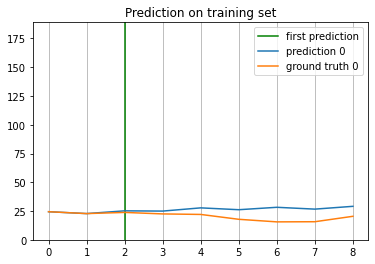

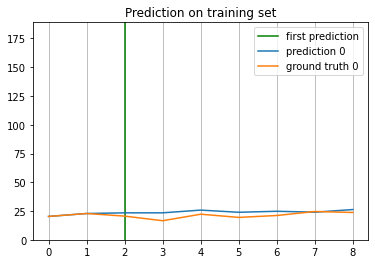

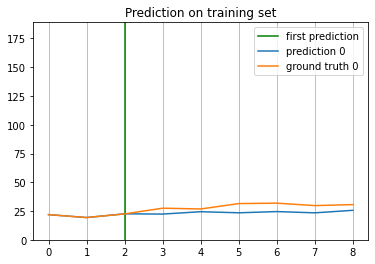

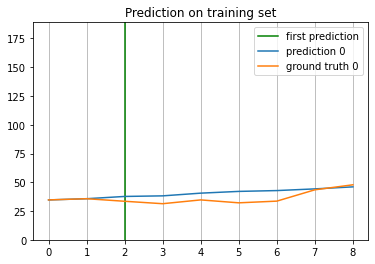

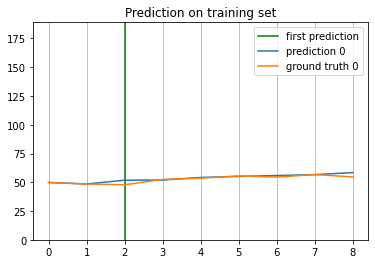

In [226]:
for i in range (start, start+limit, n_steps_in + n_steps_out):
    plt.figure()
    plt.grid(True, axis='x')
    plt.ylim(0, max(data[coordinate])+1)
    plt.title('Prediction on training set')

    plt.axvline(x=n_steps_in, ymin=0, ymax=1, label='first prediction', color='g')
    y = np.concatenate((X_train_unscaled[i], pred_train_unscaled[i]))
    x = np.arange(y.shape[0]).reshape((y.shape[0], 1))

    plt.plot(x, y, label='prediction ' + str(particle), color='tab:blue')
    plt.plot(x, data[data['particle'] == particle][coordinate][i:i+n_steps_in+n_steps_out], label='ground truth ' + str(particle), color='tab:orange')

    plt.legend()

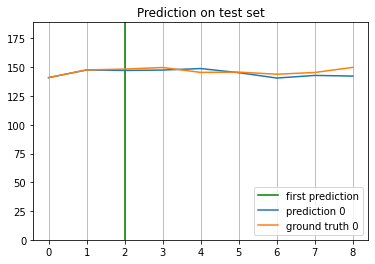

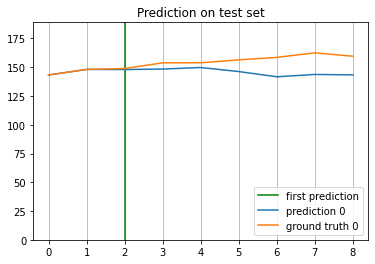

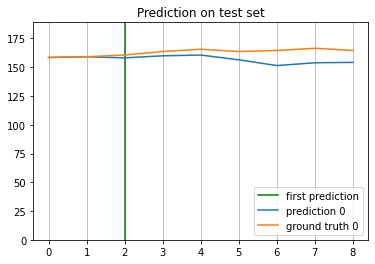

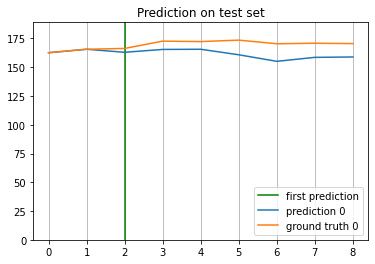

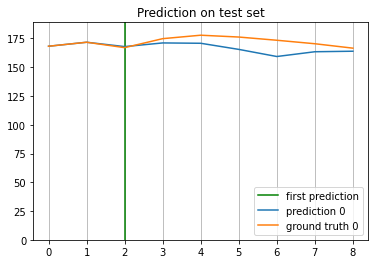

In [227]:
for i in range (start, start+limit, n_steps_in + n_steps_out):
    plt.figure()
    plt.grid(True, axis='x')
    plt.ylim(0, max(data[coordinate])+1)
    plt.title('Prediction on test set')

    plt.axvline(x=n_steps_in, ymin=0, ymax=1, label='first prediction', color='g')
    y = np.concatenate((X_test_unscaled[i], pred_test_unscaled[i]))
    x = np.arange(y.shape[0]).reshape((y.shape[0], 1))

    plt.plot(x, y, label='prediction ' + str(particle), color='tab:blue')
    plt.plot(x, data[data['particle'] == particle][coordinate][train_size+i:train_size+i+n_steps_in+n_steps_out], label='ground truth ' + str(particle), color='tab:orange')

    plt.legend()

The different values for n_in and n_out are tried in the following way:
- start from `n_in = 1` and `n_out = 1`
- increase `n_out` as long as the results are good enough
- once the results become worse, increase `n_in` until results are back to being good again
- continue this way

This could lead to some problems in the sense that we will not try some combinations and we willnot tweak the network architecture.

**Progress so far**
- `n_in` = 2
- `n_out` = 7

This seems to yield the best results su far, i.e. a good balance betweengood prediction and usage of past positions to predict future ones.

In [228]:
model.save('../../models/rnn_3.h5') 